In [4]:
# %matplotlib inline
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot
from pylab import *
%pylab inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
##Colors
cam=['#D6083B','#0072CF','#EA7125','#55A51C','#8F2BBC','#00B1C1']

#disk = 'R' # Lab computer

plotpath = '//Users//philippkoehler//OneDrive - University Of Cambridge//PhD_Cambridge//Measurements//SLM_Calibration//Plots//'

Populating the interactive namespace from numpy and matplotlib


/Users/philippkoehler/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['power', 'draw_if_interactive', 'random', 'fft', 'linalg', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
def GetVertSum(image_path):
    img = cv2.imread(image_path)
    height, width, channels = img.shape
    img_array=np.zeros((height,width))
    for w in range(0,width-1):
        for h in range(0,height-1):
            img_array[h][w]=img.item(h,w,0)+img.item(h,w,1)+img.item(h,w,2)
    values=np.sum(img_array,axis=0)
    return values

def GetVertSumShift(image_path,shift):
    img = cv2.imread(image_path)
    height, width, channels = img.shape
    img_array=np.zeros((height,width))
    for w in range(0,width-1):
        for h in range(0,height-1):
            img_array[h][w]=img.item(h,w,0)+img.item(h,w,1)+img.item(h,w,2)
    values=np.sum(img_array,axis=0)+shift
    return values

def MakeLib(path):
    lib={}
    import os
    for file in os.listdir(path):
        if file.endswith(".bmp"):
            lib['{}'.format(str(file))]=GetVertSum(path+file)
    return lib

def MakeLibShift(path,shift):
    lib={}
    import os
    for file in os.listdir(path):
        if file.endswith(".bmp"):
            lib['{}'.format(str(file))]=GetVertSumShift(path+file,shift)
    return lib

def get_corr(lib,ref,start,stop):
    shift=[]
    from scipy import signal, fftpack
    for key in lib:
        #print key
        #shift.append(np.argmax(signal.correlate(test_lib['600nm_image_1465222920.62.bmp'],test_lib[key])))
        shift.append(np.argmax(signal.correlate(lib[ref][start:stop],lib[key][start:stop]))-stop+start)
    return shift

def get_shift(lib,ref):
    shift=[]
    for key in lib:
        #print key
        #shift.append(np.argmax(signal.correlate(test_lib['600nm_image_1465222920.62.bmp'],test_lib[key])))
        shift.append(np.corrcoef(lib[ref],lib[key])[0][1])
    return shift

def plotall(lib):
    for key in lib:
        width=np.arange(0,len(lib[key]))
        plt.plot(width,lib[key])
    #plt.xlim(600,700)
    #plt.ylim(50000,120000)
    #plt.show()

def ReadData(path):
    with open(path) as f:
        lines = [float(line.rstrip('\n')) for line in open(path)]
        del lines[-1]
    return lines

def ReadDataShift(path,shift):
    with open(path) as f:
        lines = [float(line.rstrip('\n'))-shift for line in open(path)]
        del lines[-1]
    return lines

def DataLib(path):
    lib={}
    import os
    for file in os.listdir(path):
        lib['{}'.format(str(file))]=ReadData(path+file)
    return lib

def DataLibShift(path,shift):
    lib={}
    import os
    for file in os.listdir(path):
        lib['{}'.format(str(file))]=ReadDataShift(path+file,shift)
    return lib

#lib=MakeLib(path)
        

#values=GetVertSum(path+'500nm_SLM19.bmp')
#width=np.arange(1280)
#plt.plot(width,values)

def libCorr(lib):
    shift=[]
    ref='summed_data_averaged_10_times_u_1000.txt'
    print ref
    from scipy import signal, fftpack
    for key in lib:
        #print key
        #shift.append(np.argmax(signal.correlate(test_lib['600nm_image_1465222920.62.bmp'],test_lib[key])))
        shift.append(np.argmax(signal.correlate(lib[ref],lib[key]))-1279)
    return shift

def GetCCValues(lib):
    AA=np.correlate(lib['summed_data_averaged_10_times_u_1000.txt'],lib['summed_data_averaged_10_times_u_1000.txt'],'full')
    PixelShift=[]
    with rc_context(fname='plotting'):
        for i in range(1000,2000):
            CC=np.correlate(lib['summed_data_averaged_10_times_u_{}.txt'.format(i)],lib['summed_data_averaged_10_times_u_1000.txt'],'full')
            plot(np.arange(len(CC))-argmax(AA),CC)
            #print len(CC)
            PixelShift.append((argmax(CC)-argmax(AA)))
            axvline((argmax(CC)-argmax(AA)))
        #print PixelShift 
        axvline(0)
        #xlim(-100,100)
    return(PixelShift)

def MakePhase(values,number):
    output=[]
    for i in range(0,len(values)):
        output.append(float(values[i])/number*2)
    return output

def SelectTwoPeaksIntelligent(lib):
    x1=700
    x2=900
    x3=400
    x4=600
    for i in range(1000,2000):
        key='summed_data_averaged_10_times_u_{}.txt'.format(i)
        shift = min(lib[key][x3:x2])
        Min=min(lib[key][x1:x2])
        for i in range(x1,x2):
            if lib[key][i]==Min:
                UpperLim=i
            else:
                pass
        
        Min=min(lib[key][x3:x4])
        for i in range(x3,x4):
            if lib[key][i]==Min:
                LowerLim=i
            else:
                pass
        
        for i in range(0,len(lib[key])):
            if i<LowerLim:
                lib[key][i]=0
            if i>UpperLim:
                lib[key][i]=0
            if LowerLim<=i<=UpperLim:
                lib[key][i]=lib[key][i]-shift
                
        x3=LowerLim-50
        x4=LowerLim+50
        x1=UpperLim-50
        x2=UpperLim+50
    print 'For the phase calibration: 2 \pi = {}'.format((UpperLim-LowerLim)/2)
    
def ReadLUTData(path):
    data = []
    x = []
    y = []
    with open(path) as f:
        lines = [line.strip('\n') for line in f]
    for i in range(0,len(lines)):
        x.append((lines[i].split('\t'))[0])
        y.append((lines[i].split('\t'))[1])
    data = [x,y]
    return data

def ReadLUTDataSpace(path):
    data = []
    x = []
    y = []
    with open(path) as f:
        lines = [line.strip('\n') for line in f]
    for i in range(0,len(lines)):
        x.append((lines[i].split(' '))[0])
        y.append((lines[i].split(' '))[1])
    data = [x,y]
    return data

def ExtractPhaseData(MS,LowerLim,HigherLim):
    data=[]
    PercentOfBlack=np.linspace(LowerLim/10,HigherLim/10,HigherLim-LowerLim)
    for i in range(LowerLim,HigherLim):
        data.append(MS[i])
    return PercentOfBlack, data

        

# All in One Plot

In [3]:
date='2016-10-20'
wave='750-800nm'
path1='//Users//philippkoehler//OneDrive - University Of Cambridge//PhD_Cambridge//Measurements//SLM_Calibration//{}-{}//data//'.format(date,wave)
lib1=DataLib(path1)
SelectTwoPeaksIntelligent(lib1)

with rc_context(fname='plotting'):
    PS1=GetCCValues(lib1)
    xlim(-400,600)
    #plt.show()

For the phase calibration: 2 \pi = 185


In [6]:
MS1=MakePhase(PS1,185)

In [8]:
date='2016-10-19'
wave='700-750nm'
path2='//Users//philippkoehler//OneDrive - University Of Cambridge//PhD_Cambridge//Measurements//SLM_Calibration//{}-{}//data//'.format(date,wave)
lib2=DataLib(path2)
SelectTwoPeaksIntelligent(lib2)

with rc_context(fname='plotting'):
    PS2=GetCCValues(lib2)
    xlim(-400,600)
    #plt.show()

For the phase calibration: 2 \pi = 172


In [9]:
MS2=MakePhase(PS2,172)

In [10]:
date='2016-10-13'
wave='650-700nm'
path3='//Users//philippkoehler//OneDrive - University Of Cambridge//PhD_Cambridge//Measurements//SLM_Calibration//{}-{}//data//'.format(date,wave)
lib3=DataLib(path3)
SelectTwoPeaksIntelligent(lib3)

with rc_context(fname='plotting'):
    PS3=GetCCValues(lib3)
    xlim(-400,600)
    #plt.show()

For the phase calibration: 2 \pi = 158


In [11]:
MS3=MakePhase(PS3,158)

In [12]:
date='2016-10-12'
wave='600-650nm'
path4='//Users//philippkoehler//OneDrive - University Of Cambridge//PhD_Cambridge//Measurements//SLM_Calibration//{}-{}//data//'.format(date,wave)
lib4=DataLib(path4)
SelectTwoPeaksIntelligent(lib4)

with rc_context(fname='plotting'):
    PS4=GetCCValues(lib4)
    xlim(-400,600)
    #plt.show()

For the phase calibration: 2 \pi = 74


In [13]:
MS4=MakePhase(PS4,148)

In [14]:
date='2016-10-06'
wave='500-550nm'
path6='//Users//philippkoehler//OneDrive - University Of Cambridge//PhD_Cambridge//Measurements//SLM_Calibration//{}-{}//data//'.format(date,wave)
lib6=DataLib(path6)
SelectTwoPeaksIntelligent(lib6)

with rc_context(fname='plotting'):
    PS6=GetCCValues(lib6)
    xlim(-400,600)
    #plt.show()

For the phase calibration: 2 \pi = 127


In [15]:
MS6=MakePhase(PS6,127)

In [16]:
date='2016-10-04'
wave='550-600nm'
path5='//Users//philippkoehler//OneDrive - University Of Cambridge//PhD_Cambridge//Measurements//SLM_Calibration//{}-{}//data//'.format(date,wave)
lib5=DataLib(path5)
SelectTwoPeaksIntelligent(lib5)

with rc_context(fname='plotting'):
    PS5=GetCCValues(lib5)
    xlim(-400,600)
    #plt.show()

For the phase calibration: 2 \pi = 139


In [17]:
MS5=MakePhase(PS5,139)

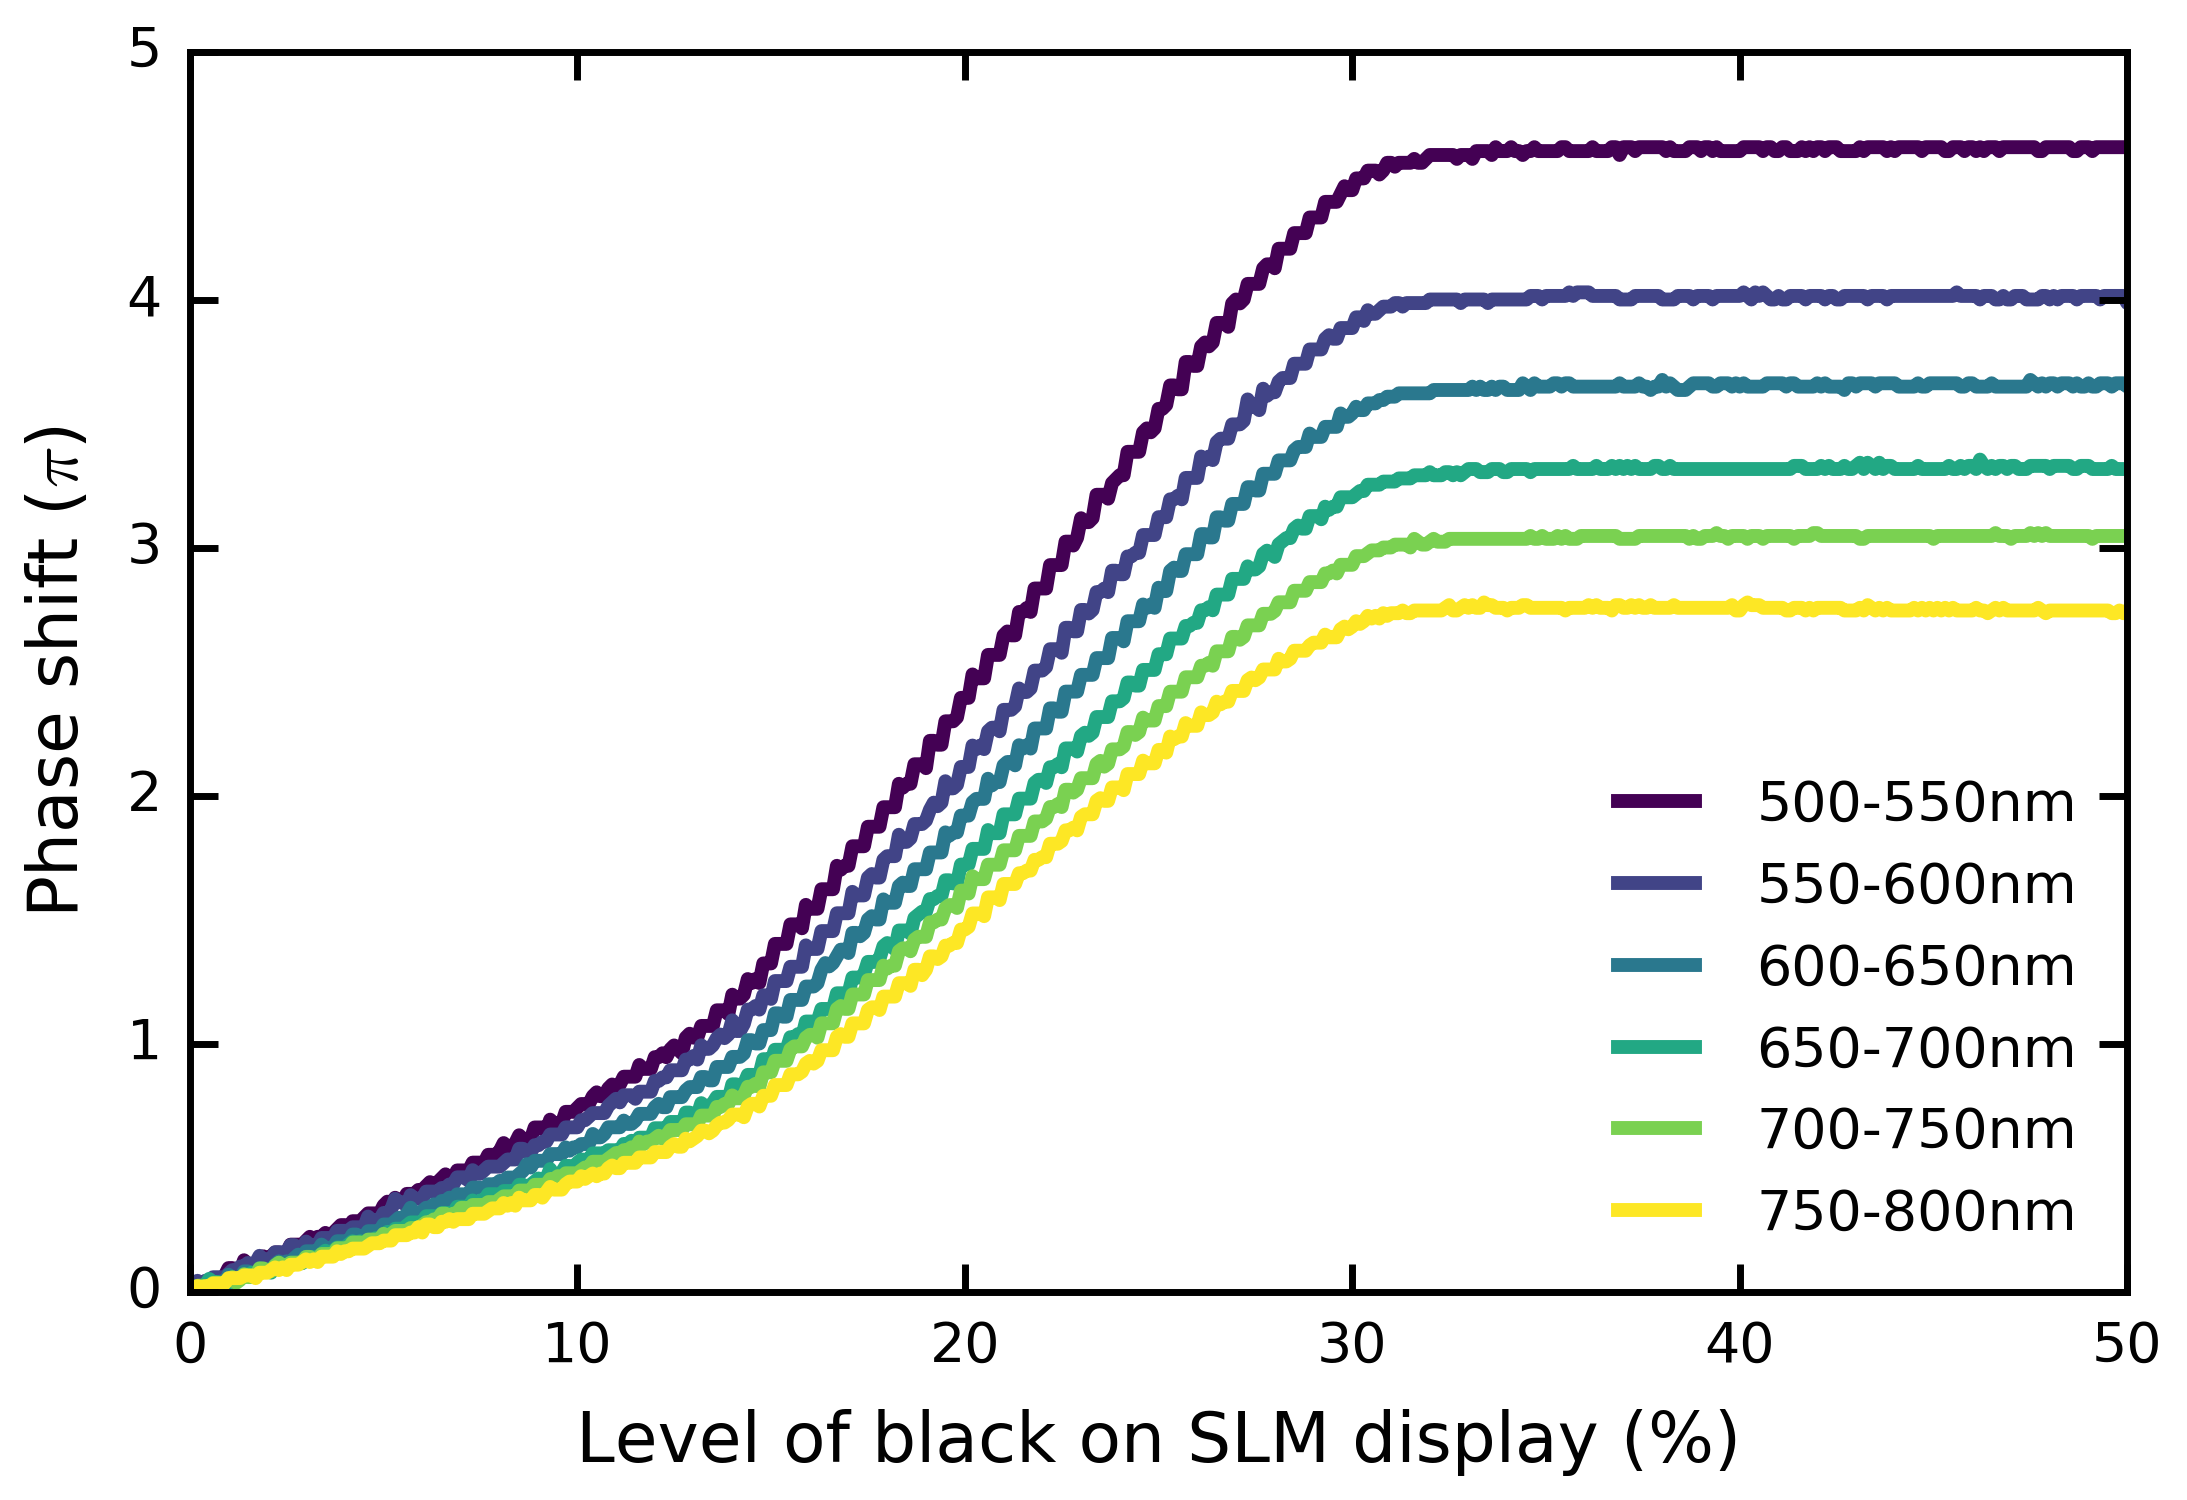

In [19]:
jet = plt.get_cmap('viridis') 
values = range(6)
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
wavelengths=['500-550nm','550-600nm','600-650nm','650-700nm','700-750nm','750-800nm']

with rc_context(fname='plotting'):
    k=-1
    for i in [[PS6,MS6],[PS5,MS5],[PS4,MS4],[PS3,MS3],[PS2,MS2],[PS1,MS1]]:
        k=k+1
        plot(np.arange(0,len(i[0])/10,0.1),i[1],color=scalarMap.to_rgba(values[k]),label=wavelengths[k])
    #plot(np.arange(0,len(PS6)/10,0.1),MS5,color=cam[1],label=wave)
    legend(loc=4)
    ylim(0,5)
    xlim(0,50)
    ylabel('Phase shift ($\pi$)')
    xlabel('Level of black on SLM display (%)')
    #axhline(lowP,color='black',linewidth=1, linestyle='--')
    #axhline(highP,color='black',linewidth=1, linestyle='--')
    #annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    #annotate(s='', xy=(low,4), xytext=(high,4), arrowprops=dict(arrowstyle='<->'))
    #text(6,highP-1,'2$\pi$',rotation=90)
    #axvline(low,color='black',linewidth=1, linestyle='--')
    #axvline(high,color='black',linewidth=1, linestyle='--')
    #text(low-5.2,3.93,'{}%'.format(str(low)))
    #text(high+.5,3.93,'{}%'.format(str(high)))
    for i in ['pdf','jpg']:
        savefig(plotpath+'All_in_1_SLM_Calibration_Curve.{}'.format(i))
    plt.show()

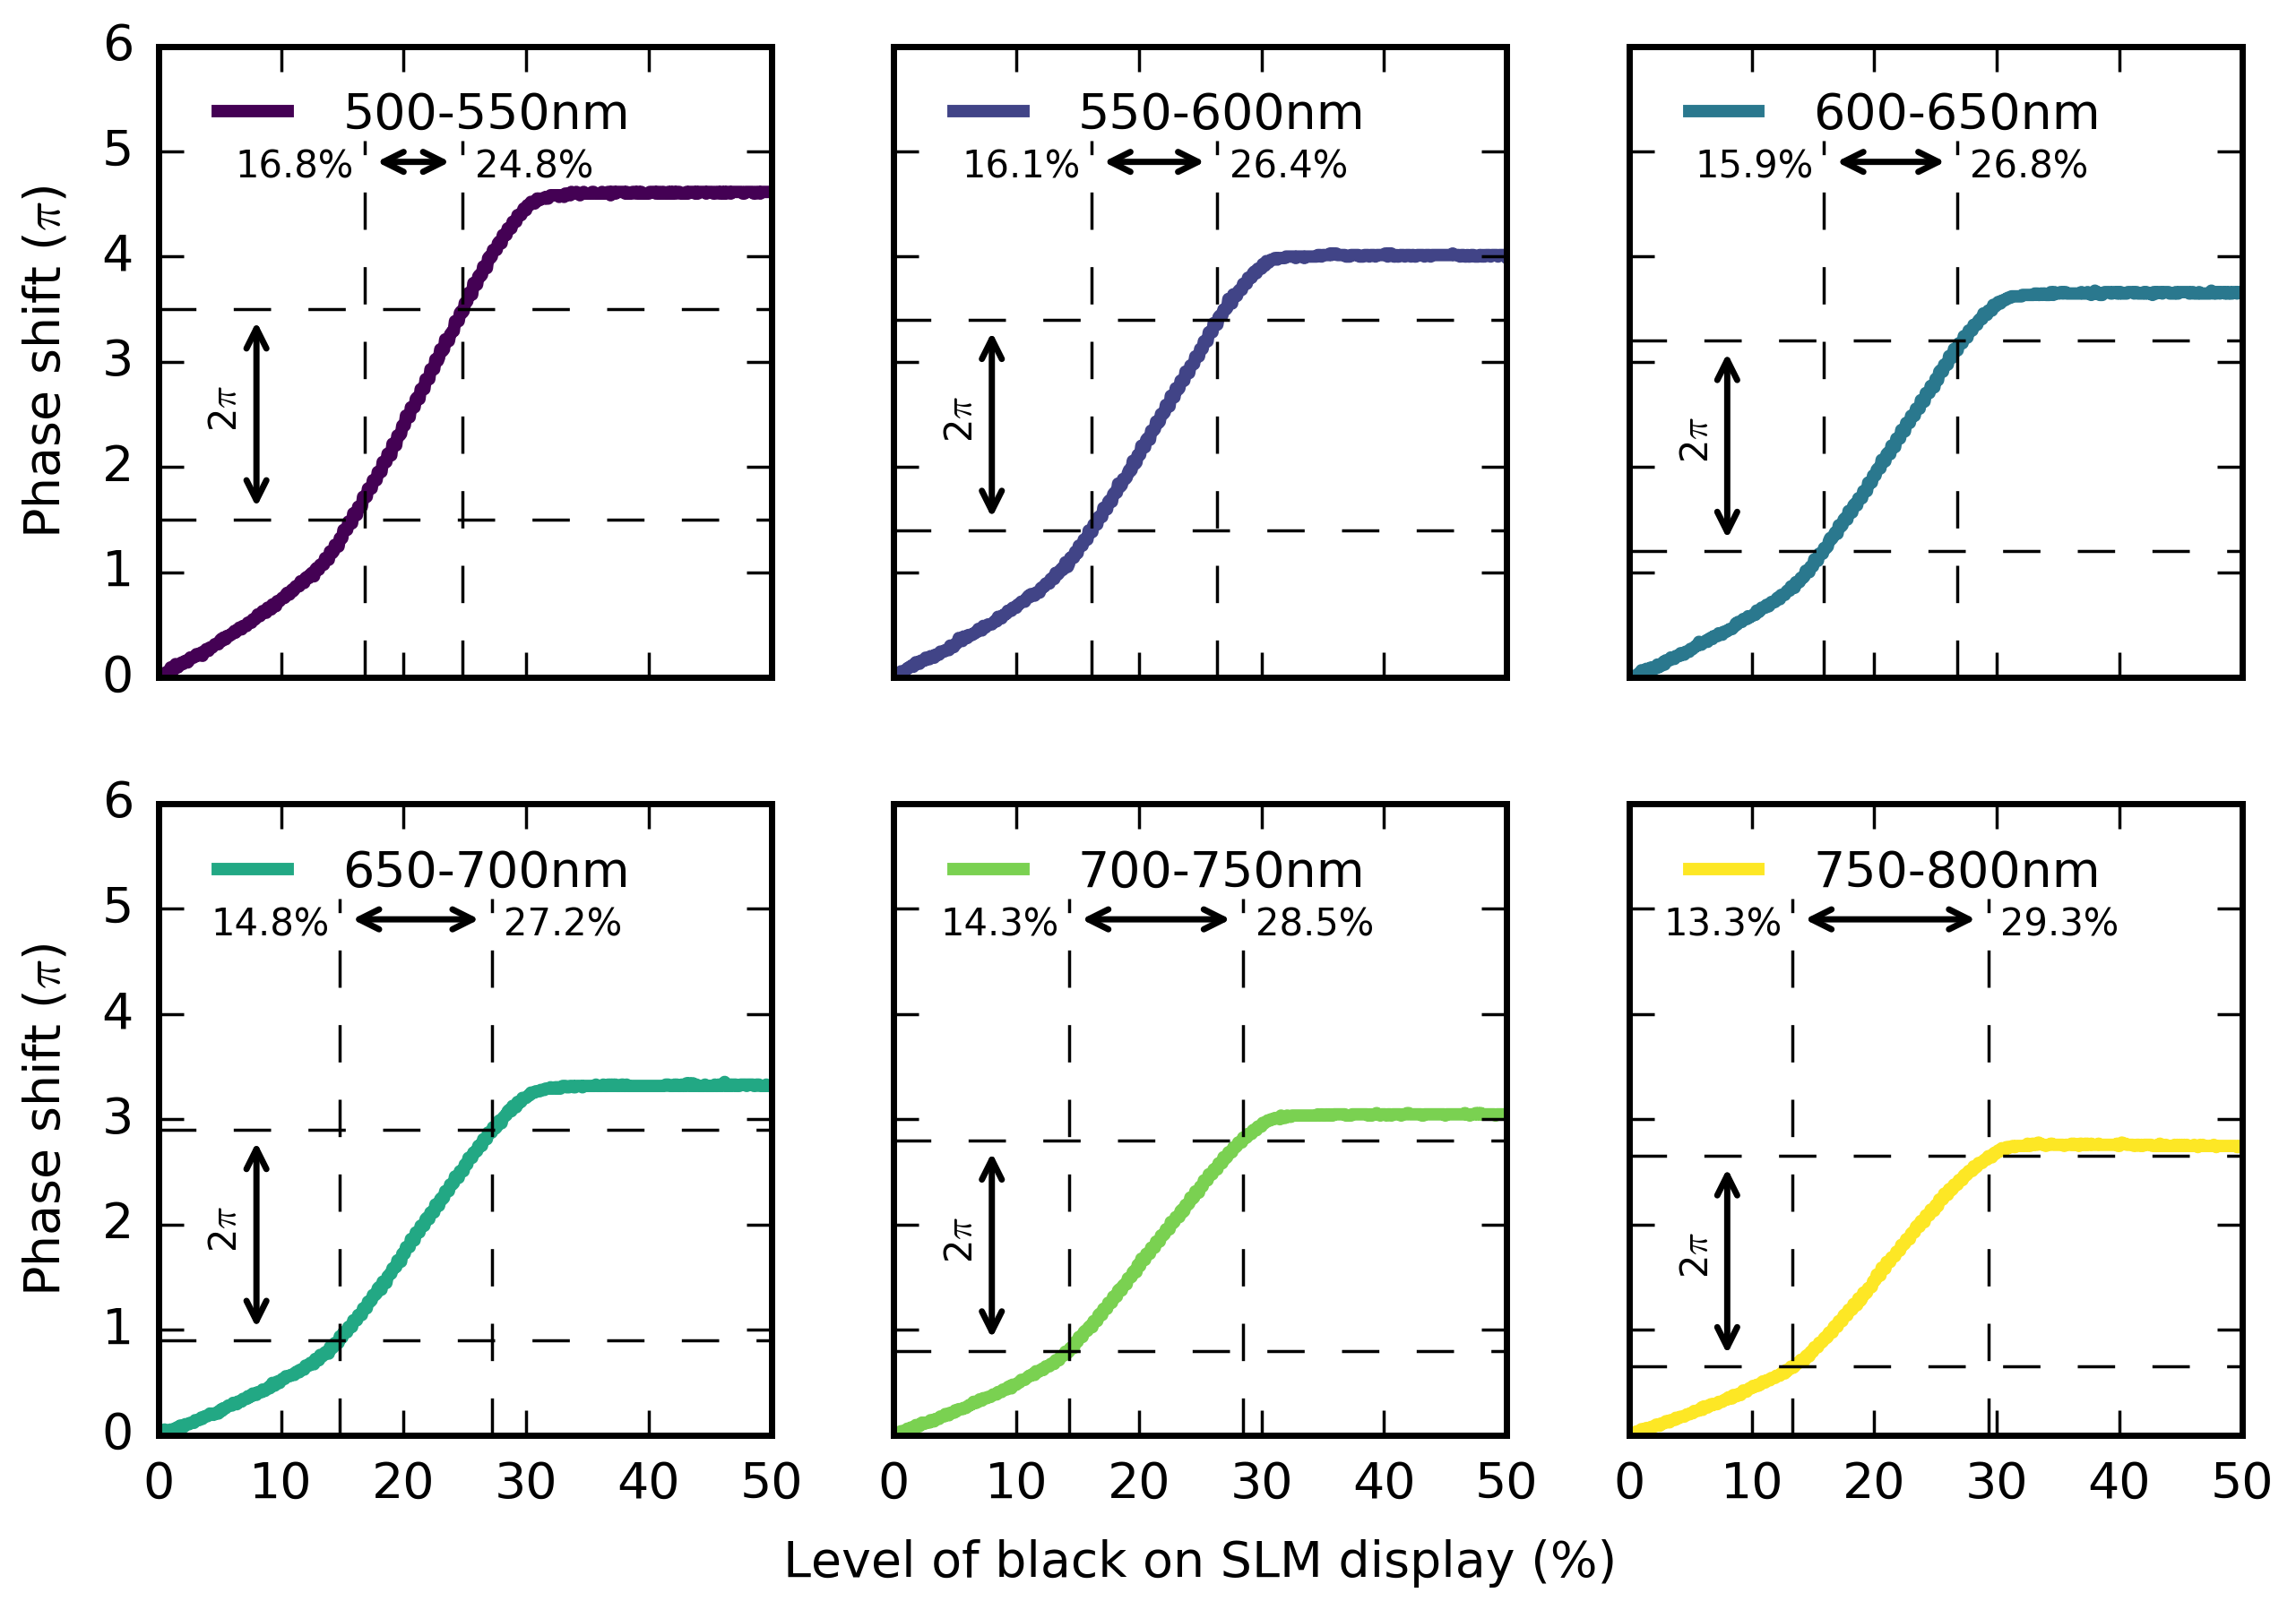

In [20]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')


with rc_context(fname='plotting_subplots'):
    ax6.plot(np.arange(0,len(PS1)/10,0.1),MS1,color=scalarMap.to_rgba(values[5]),label=wavelengths[5])
    ax6.legend(loc=2)
    ax6.set_ylim(0,6)
    ax6.set_xlim(0,50)
    
    ax5.plot(np.arange(0,len(PS2)/10,0.1),MS2,color=scalarMap.to_rgba(values[4]),label=wavelengths[4])
    ax5.legend(loc=2)
    ax5.set_ylim(0,6)
    ax5.set_xlim(0,50)
    
    ax4.plot(np.arange(0,len(PS3)/10,0.1),MS3,color=scalarMap.to_rgba(values[3]),label=wavelengths[3])
    ax4.legend(loc=2)
    ax4.set_ylim(0,6)
    ax4.set_xlim(0,50)
    
    ax3.plot(np.arange(0,len(PS4)/10,0.1),MS4,color=scalarMap.to_rgba(values[2]),label=wavelengths[2])
    ax3.legend(loc=2)
    ax3.set_ylim(0,6)
    ax3.set_xlim(0,50)
    
    ax2.plot(np.arange(0,len(PS5)/10,0.1),MS5,color=scalarMap.to_rgba(values[1]),label=wavelengths[1])
    ax2.legend(loc=2)
    ax2.set_ylim(0,6)
    ax2.set_xlim(0,50)
    
    ax1.plot(np.arange(0,len(PS6)/10,0.1),MS6,color=scalarMap.to_rgba(values[0]),label=wavelengths[0])
    ax1.legend(loc=2)
    ax1.set_ylim(0,6)
    ax1.set_xlim(0,50)
    
    low=13.3
    high=29.3
    lowP=0.65
    highP=2.65
    
    ax6.axhline(lowP,color='black',linewidth=.5, linestyle='--')
    ax6.axhline(highP,color='black',linewidth=.5, linestyle='--')
    ax6.annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    ax6.annotate(s='', xy=(low,4.9), xytext=(high,4.9), arrowprops=dict(arrowstyle='<->'))
    ax6.text(4,highP-1,'2$\pi$',rotation=90,size=6)
    ax6.axvline(low,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax6.axvline(high,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax6.text(low-10.5,4.75,'{}%'.format(str(low)),size=6)
    ax6.text(high+1,4.75,'{}%'.format(str(high)),size=6)
    
    
    low=14.3
    high=28.5
    lowP=0.8
    highP=2.8
    
    ax5.axhline(lowP,color='black',linewidth=.5, linestyle='--')
    ax5.axhline(highP,color='black',linewidth=.5, linestyle='--')
    ax5.annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    ax5.annotate(s='', xy=(low,4.9), xytext=(high,4.9), arrowprops=dict(arrowstyle='<->'))
    ax5.text(4,highP-1,'2$\pi$',rotation=90,size=6)
    ax5.axvline(low,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax5.axvline(high,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax5.text(low-10.5,4.75,'{}%'.format(str(low)),size=6)
    ax5.text(high+1,4.75,'{}%'.format(str(high)),size=6)
    
    low=14.8
    high=27.2
    lowP=0.9
    highP=2.9
    
    ax4.axhline(lowP,color='black',linewidth=.5, linestyle='--')
    ax4.axhline(highP,color='black',linewidth=.5, linestyle='--')
    ax4.annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    ax4.annotate(s='', xy=(low,4.9), xytext=(high,4.9), arrowprops=dict(arrowstyle='<->'))
    ax4.text(4,highP-1,'2$\pi$',rotation=90,size=6)
    ax4.axvline(low,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax4.axvline(high,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax4.text(low-10.5,4.75,'{}%'.format(str(low)),size=6)
    ax4.text(high+1,4.75,'{}%'.format(str(high)),size=6)
    
    low=16.8
    high=24.8
    lowP=1.5
    highP=3.5
    
    ax1.axhline(lowP,color='black',linewidth=.5, linestyle='--')
    ax1.axhline(highP,color='black',linewidth=.5, linestyle='--')
    ax1.annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    ax1.annotate(s='', xy=(low,4.9), xytext=(high,4.9), arrowprops=dict(arrowstyle='<->'))
    ax1.text(4,highP-1,'2$\pi$',rotation=90,size=6)
    ax1.axvline(low,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax1.axvline(high,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax1.text(low-10.5,4.75,'{}%'.format(str(low)),size=6)
    ax1.text(high+1,4.75,'{}%'.format(str(high)),size=6)
    
    low=16.1
    high=26.4
    lowP=1.4
    highP=3.4
    
    ax2.axhline(lowP,color='black',linewidth=.5, linestyle='--')
    ax2.axhline(highP,color='black',linewidth=.5, linestyle='--')
    ax2.annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    ax2.annotate(s='', xy=(low,4.9), xytext=(high,4.9), arrowprops=dict(arrowstyle='<->'))
    ax2.text(4,highP-1,'2$\pi$',rotation=90,size=6)
    ax2.axvline(low,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax2.axvline(high,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax2.text(low-10.5,4.75,'{}%'.format(str(low)),size=6)
    ax2.text(high+1,4.75,'{}%'.format(str(high)),size=6)
    
    low=15.9
    high=26.8
    lowP=1.2
    highP=3.2
    
    ax3.axhline(lowP,color='black',linewidth=.5, linestyle='--')
    ax3.axhline(highP,color='black',linewidth=.5, linestyle='--')
    ax3.annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    ax3.annotate(s='', xy=(low,4.9), xytext=(high,4.9), arrowprops=dict(arrowstyle='<->'))
    ax3.text(4,highP-1,'2$\pi$',rotation=90,size=6)
    ax3.axvline(low,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax3.axvline(high,ymin=0,ymax=.85,color='black',linewidth=.5, linestyle='--')
    ax3.text(low-10.5,4.75,'{}%'.format(str(low)),size=6)
    ax3.text(high+1,4.75,'{}%'.format(str(high)),size=6)
    
    ax1.set_ylabel('Phase shift ($\pi$)')
    ax4.set_ylabel('Phase shift ($\pi$)')
    ax5.set_xlabel('Level of black on SLM display (%)')
    
    #plt.tight_layout()

    #axhline(lowP,color='black',linewidth=1, linestyle='--')
    #axhline(highP,color='black',linewidth=1, linestyle='--')
    #annotate(s='', xy=(8,lowP), xytext=(8,highP), arrowprops=dict(arrowstyle='<->'))
    #annotate(s='', xy=(low,4), xytext=(high,4), arrowprops=dict(arrowstyle='<->'))
    #text(6,highP-1,'2$\pi$',rotation=90)
    #axvline(low,color='black',linewidth=1, linestyle='--')
    #axvline(high,color='black',linewidth=1, linestyle='--')
    #text(low-5.2,3.93,'{}%'.format(str(low)))
    #text(high+.5,3.93,'{}%'.format(str(high)))
    for i in ['pdf','jpg']:
        savefig(plotpath+'All_in_1_SLM_Evaluation.{}'.format(i))
    plt.show()

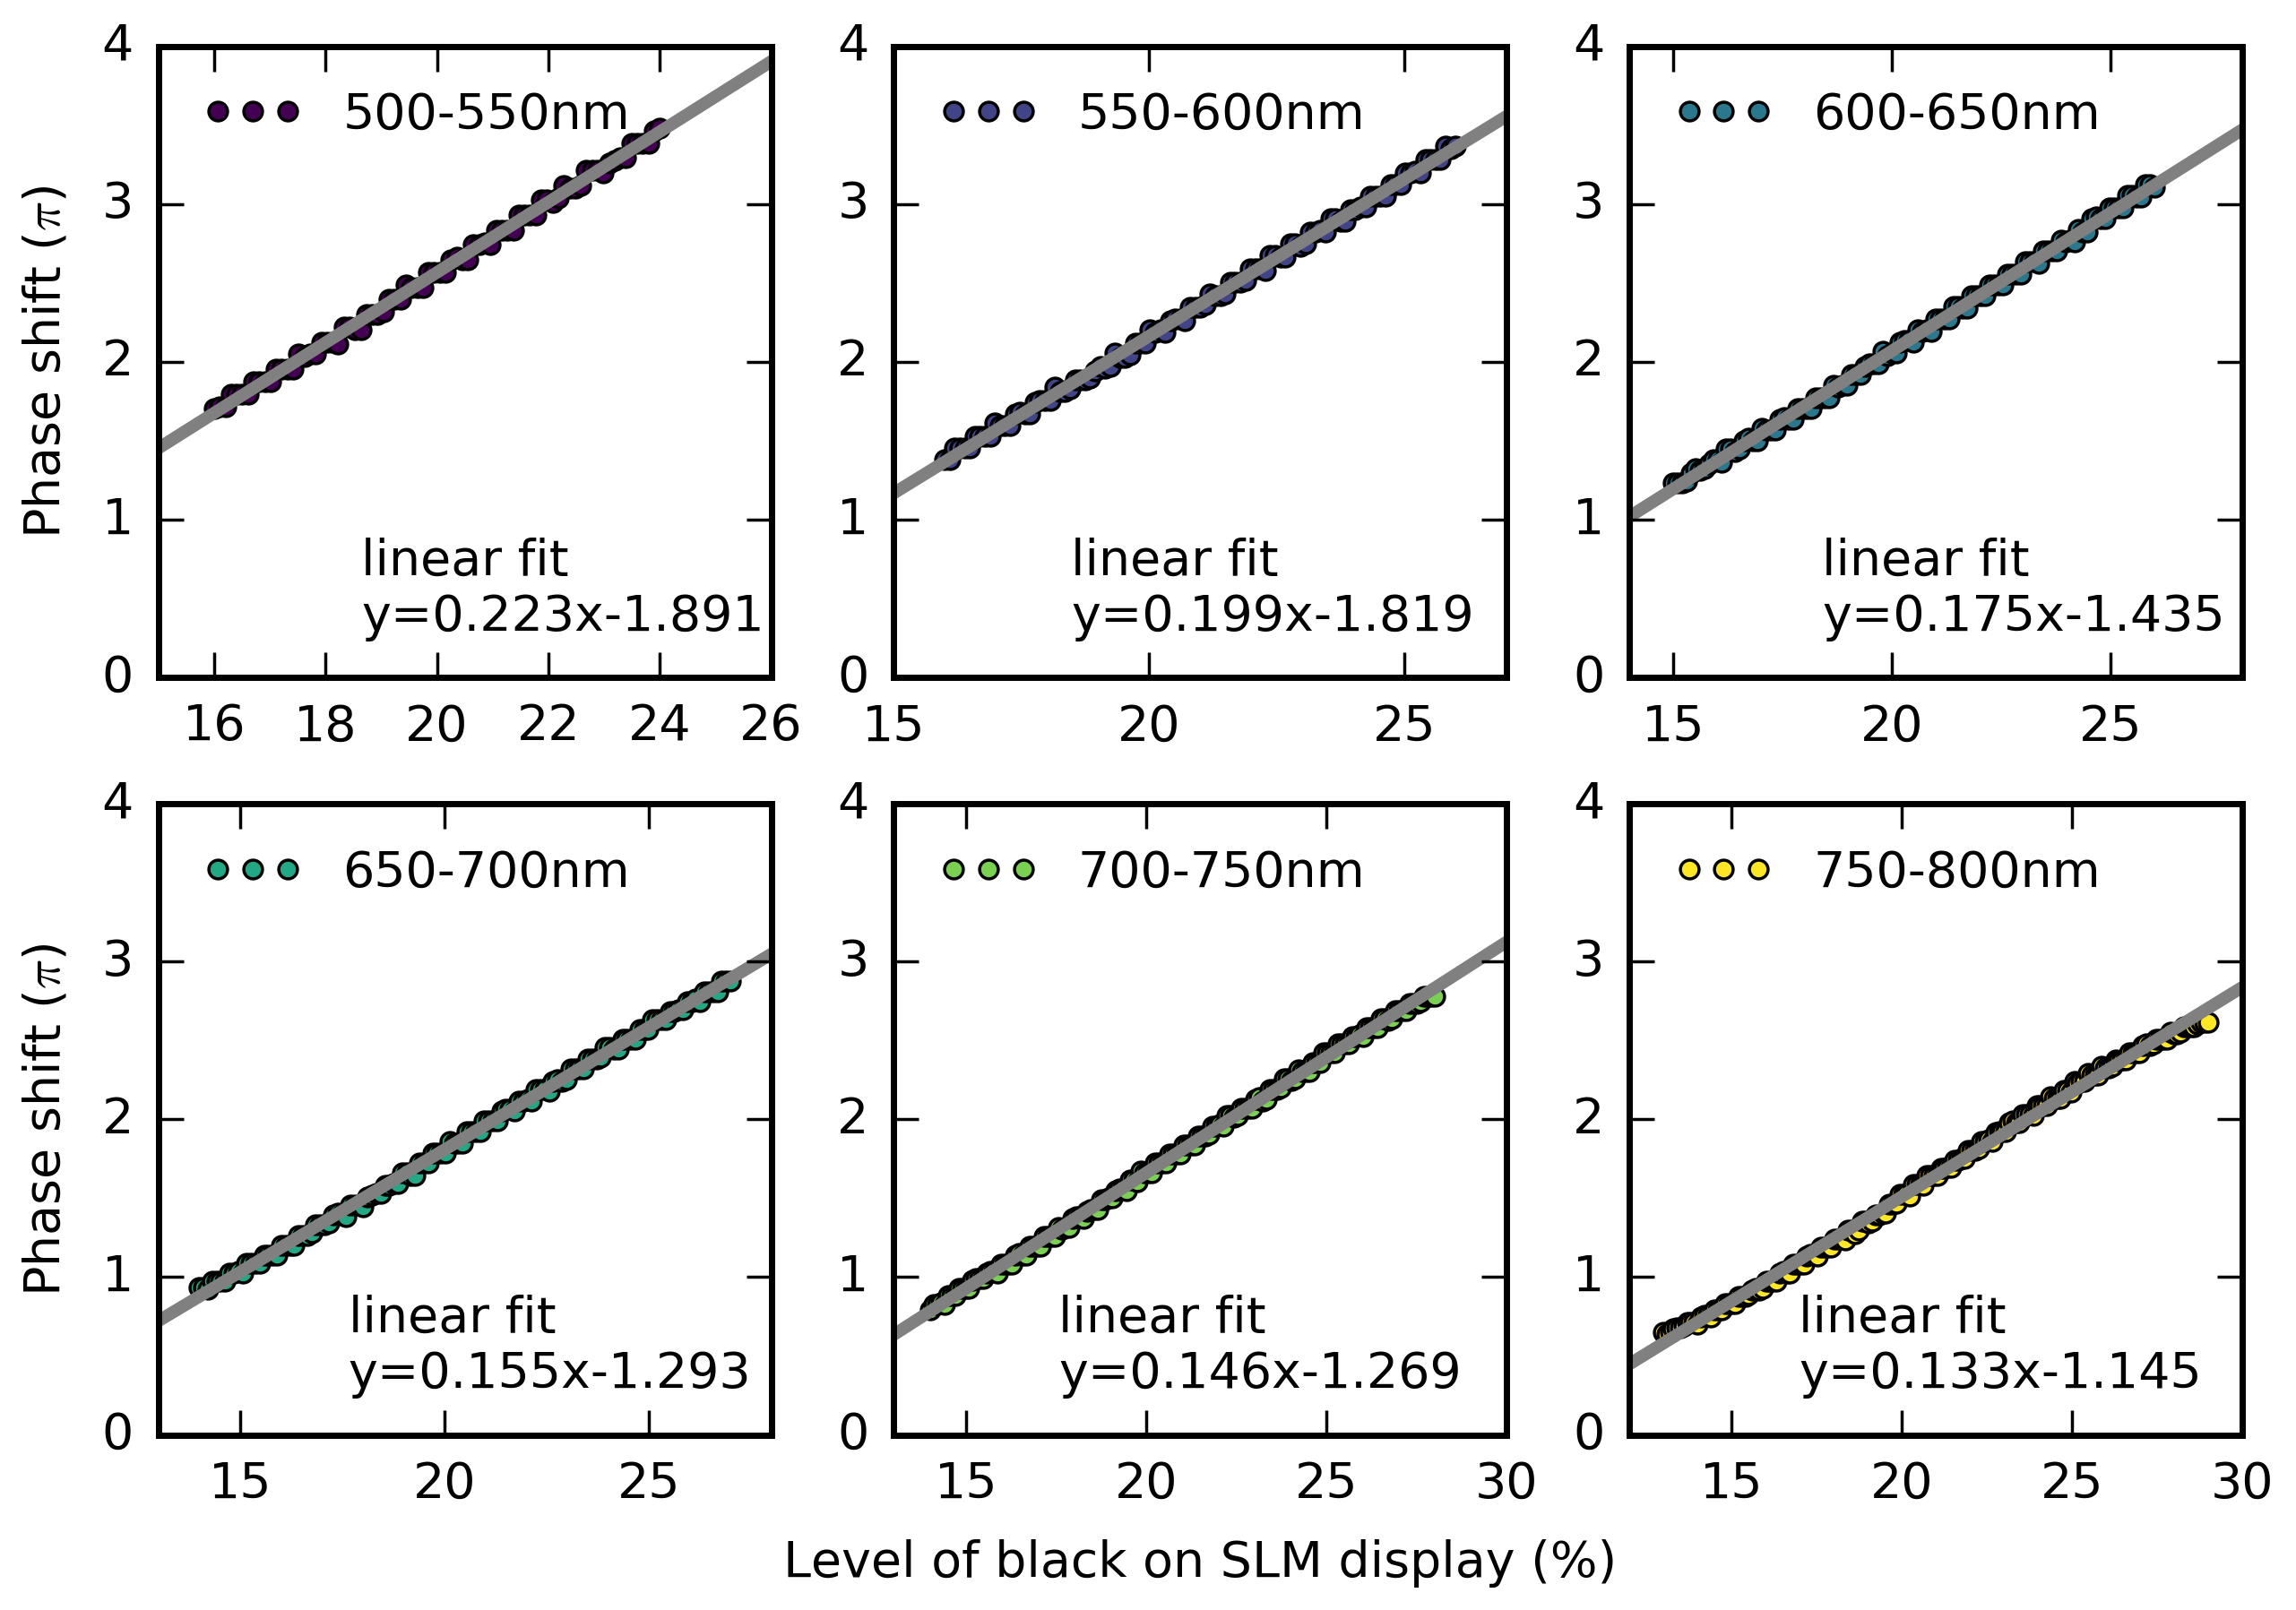

In [21]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)#, sharex='col', sharey='row')


with rc_context(fname='plotting_subplots'):
    
    ax1.locator_params(nbins=6)
    ax2.locator_params(nbins=6)
    ax3.locator_params(nbins=6)
    ax4.locator_params(nbins=6)
    ax5.locator_params(nbins=6)
    ax6.locator_params(nbins=6)
    
    low=13.3
    high=29.3
    lowP=0.65
    highP=2.65
    EPD=ExtractPhaseData(MS1,int(low*10),int(high*10))
    m,b = np.polyfit(EPD[0],EPD[1], 1)
    x=np.arange(low-2,high+2,0.01)
    y=m*x+b
    
    ax6.plot(EPD[0],EPD[1],'o',color=scalarMap.to_rgba(values[5]),markersize=3,label='{}'.format(wavelengths[5]))
    ax6.set_xlim(round(low-1),round(high+1))
    ax6.set_ylim(0,4)
    ax6.plot(x,y,color='grey')
    ax6.text(low+0.23*(high-low),0.3,'linear fit \ny={}x{}'.format(round(m,3),round(b,3)))
    ax6.legend(loc=2)
    
    low=14.3
    high=28.5
    lowP=0.8
    highP=2.8
    EPD=ExtractPhaseData(MS2,int(low*10),int(high*10))
    m,b = np.polyfit(EPD[0],EPD[1], 1)
    x=np.arange(low-2,high+2,0.01)
    y=m*x+b
    
    ax5.plot(EPD[0],EPD[1],'o',color=scalarMap.to_rgba(values[4]),markersize=3,label='{}'.format(wavelengths[4]))
    ax5.set_xlim(round(low-1),round(high+1))
    ax5.set_ylim(0,4)
    ax5.plot(x,y,color='grey')
    ax5.text(low+0.23*(high-low),0.3,'linear fit \ny={}x{}'.format(round(m,3),round(b,3)))
    ax5.legend(loc=2)
    
    low=14.8
    high=27.2
    lowP=0.9
    highP=2.9
    EPD=ExtractPhaseData(MS3,int(low*10),int(high*10))
    m,b = np.polyfit(EPD[0],EPD[1], 1)
    x=np.arange(low-2,high+2,0.01)
    y=m*x+b
    
    ax4.plot(EPD[0],EPD[1],'o',color=scalarMap.to_rgba(values[3]),markersize=3,label='{}'.format(wavelengths[3]))
    ax4.set_xlim(round(low-2),round(high+1))
    ax4.set_ylim(0,4)
    ax4.plot(x,y,color='grey')
    ax4.text(low+0.23*(high-low),0.3,'linear fit \ny={}x{}'.format(round(m,3),round(b,3)))
    ax4.legend(loc=2)
    
    low=16.8
    high=24.8
    lowP=1.5
    highP=3.5
    EPD=ExtractPhaseData(MS6,int(low*10),int(high*10))
    m,b = np.polyfit(EPD[0],EPD[1], 1)
    x=np.arange(low-2,high+2,0.01)
    y=m*x+b
    
    ax1.plot(EPD[0],EPD[1],'o',color=scalarMap.to_rgba(values[0]),markersize=3,label='{}'.format(wavelengths[0]))
    ax1.set_xlim(round(low-2),round(high+1))
    ax1.set_ylim(0,4)
    ax1.plot(x,y,color='grey')
    ax1.text(low+0.23*(high-low),0.3,'linear fit \ny={}x{}'.format(round(m,3),round(b,3)))
    ax1.legend(loc=2)
    
    low=16.1
    high=26.4
    lowP=1.4
    highP=3.4
    EPD=ExtractPhaseData(MS5,int(low*10),int(high*10))
    m,b = np.polyfit(EPD[0],EPD[1], 1)
    x=np.arange(low-2,high+2,0.01)
    y=m*x+b
    
    ax2.plot(EPD[0],EPD[1],'o',color=scalarMap.to_rgba(values[1]),markersize=3,label='{}'.format(wavelengths[1]))
    ax2.set_xlim(round(low-1),round(high+1))
    ax2.set_ylim(0,4)
    ax2.plot(x,y,color='grey')
    ax2.text(low+0.23*(high-low),0.3,'linear fit \ny={}x{}'.format(round(m,3),round(b,3)))
    ax2.legend(loc=2)
    
    low=15.9
    high=26.8
    lowP=1.2
    highP=3.2
    EPD=ExtractPhaseData(MS4,int(low*10),int(high*10))
    m,b = np.polyfit(EPD[0],EPD[1], 1)
    x=np.arange(low-2,high+2,0.01)
    y=m*x+b
    
    ax3.plot(EPD[0],EPD[1],'o',color=scalarMap.to_rgba(values[2]),markersize=3,label='{}'.format(wavelengths[2]))
    ax3.set_xlim(round(low-2),round(high+1))
    ax3.set_ylim(0,4)
    ax3.plot(x,y,color='grey')
    ax3.text(low+0.23*(high-low),0.3,'linear fit \ny={}x{}'.format(round(m,3),round(b,3)))
    ax3.legend(loc=2)
    
    ax1.set_ylabel('Phase shift ($\pi$)')
    ax4.set_ylabel('Phase shift ($\pi$)')
    ax5.set_xlabel('Level of black on SLM display (%)')

    for i in ['pdf','jpg']:
        savefig(plotpath+'All_in_1_SLM_Fit.{}'.format(i))
    plt.show()

##### 